# Log Analysis and Visulization 2020-02-26 Stress Test

- add interactive mode
    - TODO: visualization on jupyter notebook will fail sometimes, but saved successfully
- add the options to switch drawing different graphs.
- add the script to get the row when the blockchain restarts
- add the function to select time window using parameters: start_time, end_time
- add the function to draw features for each shard
- add the function to draw staking features for each shard, e.g creating validator per second, editing validator per second, delegating per second, undelegating per second, collecting rewards per second

In [1]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import os
import shutil
import datetime
import plotly.express as px 
import plotly.graph_objects as go

## a) parse log file

In [2]:
# read the log file
def is_json(myjson):
    try:
        json_object = json.loads(myjson)
    except ValueError as e:
        return False
    return True
 
def read_data(files, path):
    data = []
    for file in files:
        with open(path + file, errors='ignore') as f:
            for line in f.readlines():
                try: 
                    if not is_json(line):
                        continue
                    data.append(json.loads(line))
                except:
                    print('bad json: ', line)
    return data

## b) data processing and analysis

In [3]:
# convert the data into pandas dataframe
def data_processing(data, start_time, end_time):
    # start_time format  '2020-02-27 06:00:00'
    df = pd.DataFrame(data) 

    # convert timestamp to datetime64[ns] 
    df["timestamp"] = df["timestamp"].apply(lambda t: t.replace(" +0000 UTC",""))
    df["timestamp"] = pd.to_datetime(df['timestamp'])
    df = df[(df['timestamp'] > start_time) & (df['timestamp'] < end_time)]
    
    # convert all the keys in the staking into columns, fill nan values
    df = pd.concat([df.drop(['staking'], axis=1), df['staking'].apply(pd.Series)], axis=1)
    df.fillna(0, inplace = True)

    # drop duplicates
    df.drop_duplicates(inplace = True)

    # sort by timestamp 
    df.sort_values(by=['timestamp'], inplace = True)


    
    # do calculation for each shard
    shard = []
    for name, s in df.groupby("shard"):
        shard.append(s.reset_index(drop = True))
    
    # calculate the average time per block, transaction_per_second
    for s in shard:
        # time per block
        s["time_diff"] = (s['timestamp']-s['timestamp'].shift()).fillna(pd.Timedelta(seconds=0))
        s["block_diff"] = (s['block']-s['block'].shift()).fillna(0).astype(int)
        s["time_per_block"] = s.apply(lambda c: c["time_diff"].seconds /c["block_diff"] \
                                      if c["block_diff"] != 0 else np.nan, axis = 1)

        # plain transaction_per_second
        s["transaction_per_second"] = s.apply(lambda c: c["transactions"]/c["time_diff"].seconds  \
                                              if c["time_diff"].seconds != 0 else np.nan, axis = 1)
        # staking transaction_per_second
        s["staking_transaction_per_second"] = s.apply(lambda c: c["total"]/c["time_diff"].seconds \
                                              if c["time_diff"].seconds != 0 else np.nan, axis = 1)
        # total transacton per second
        s["total_transaction_per_second"] = s["transaction_per_second"] + s["staking_transaction_per_second"]

        # info for staking
        s.rename(columns={"total": "total_staking"}, inplace = True)
        if "CreateValidator" in s.columns:
            # create validator per second
            s["create_validator_per_second"] = s.apply(lambda c: c["CreateValidator"]/c["time_diff"].seconds \
                                                       if c["time_diff"].seconds != 0 else np.nan, axis = 1)
        if "EditValidator" in s.columns:
            # edit validator per second
            s["edit_validator_per_second"] = s.apply(lambda c: c["EditValidator"]/c["time_diff"].seconds \
                                                       if c["time_diff"].seconds != 0 else np.nan, axis = 1)
        if "Delegate" in s.columns:
            # delegate per second
            s["delegate_per_second"] = s.apply(lambda c: c["Delegate"]/c["time_diff"].seconds \
                                                       if c["time_diff"].seconds != 0 else np.nan, axis = 1)
        if "Undelegate" in s.columns:
            # undelegate per second
            s["undelegate_per_second"] = s.apply(lambda c: c["Undelegate"]/c["time_diff"].seconds \
                                                       if c["time_diff"].seconds != 0 else np.nan, axis = 1)
        if "CollectRewards" in s.columns:
            # CollectRewards per second
            s["collect_rewards_per_second"] = s.apply(lambda c: c["CollectRewards"]/c["time_diff"].seconds \
                                                       if c["time_diff"].seconds != 0 else np.nan, axis = 1)
            
        s.drop(['time_diff', 'block_diff'], axis=1, inplace = True)
        s.dropna(inplace = True)
        
    return shard

## c) draw the graph 

In [4]:
# draw the graphs with x-axis time
def draw_graph_time(df, fig_path, colors):
    
    html_path = fig_dir + "html/"
    png_path = fig_dir + "png/"

    print("Features vs Time")
    print("PNG saved in " + png_path)
    print("==================================")
    if not os.path.exists(html_path):
        os.makedirs(html_path)
        
    if not os.path.exists(png_path):
        os.makedirs(png_path)
    
    hover = df.columns.tolist()
    
    fig = px.line(df, x="timestamp", y="staking_transaction_per_second", color='shard', color_discrete_sequence=colors, \
                  title = 'Staking Transaction Per Second vs Time', hover_data=hover)
    fig.update_layout(xaxis_title="utc_time")
    fig.show(renderer="svg",width=900, height=500)
    fig.write_html(html_path + "staking_transaction_per_second_vs_time.html")
    fig.write_image(png_path + "staking_transaction_per_second_vs_time.png",width=900, height=500)
    
    fig = px.line(df, x="timestamp", y="total_transaction_per_second", color='shard', color_discrete_sequence=colors, \
                  title = 'Total Transaction Per Second vs Time', hover_data=hover)
    fig.update_layout(xaxis_title="utc_time")
    fig.show(renderer="svg",width=900, height=500)
    fig.write_html(html_path + "total_transaction_per_second_vs_time.html")
    fig.write_image(png_path + "total_transaction_per_second_vs_time.png",width=900, height=500)
                    
    fig = px.line(df, x='timestamp', y='transaction_per_second', color='shard', color_discrete_sequence=colors, \
                  title = 'Transaction Per Second vs Time', hover_data=hover)
    fig.update_layout(xaxis_title="utc_time")
    fig.show(renderer="svg",width=900, height=500)
    fig.write_html(html_path + "transaction_per_second_vs_time.html")
    fig.write_image(png_path + "transaction_per_second_vs_time.png",width=900, height=500)
                    
    fig = px.line(df, x="timestamp", y="time_per_block", color='shard', color_discrete_sequence=colors, \
                  title = 'Time Per Block vs Time', hover_data=hover)
    fig.update_layout(xaxis_title="utc_time")
    fig.show(renderer="svg",width=900, height=500)
    fig.write_html(html_path + "time_per_block_vs_time.html")
    fig.write_image(png_path + "time_per_block_vs_time.png",width=900, height=500)
    
    fig = px.line(df, x="timestamp", y="size", color='shard', color_discrete_sequence=colors, \
                  title = 'Size vs Time', hover_data=hover)
    fig.update_layout(xaxis_title="utc_time")
    fig.show(renderer="svg",width=900, height=500)
    fig.write_html(html_path + "size_vs_time.html")
    fig.write_image(png_path + "size_vs_time.png",width=900, height=500)
    
    fig = px.line(df, x="timestamp", y="gas", color='shard', color_discrete_sequence=colors, \
                  title = 'Gas vs Time', hover_data=hover)
    fig.update_layout(xaxis_title="utc_time")
    fig.show(renderer="svg",width=900, height=500)
    fig.write_html(html_path + "gas_vs_time.html")
    fig.write_image(png_path + "gas_vs_time.png",width=900, height=500)
    

In [5]:
# draw the graphs with x-axis block height
def draw_graph_block(df, fig_path, colors):

    html_path = fig_path + "html/"
    png_path = fig_path + "png/"

    print("Features vs Block Height")
    print("PNG saved in " + png_path)
    print("==================================")
    if not os.path.exists(html_path):
        os.makedirs(html_path)
        
    if not os.path.exists(png_path):
        os.makedirs(png_path)
    
    hover = df.columns.tolist()
    
    fig = px.line(df, x="block", y="staking_transaction_per_second", color='shard', color_discrete_sequence=colors, \
                  title = 'Staking Transaction Per Second vs Block Height', hover_data=hover)
    fig.show(renderer="svg",width=900, height=500)
    fig.write_html(html_path + "staking_transaction_per_second_vs_block_height.html")
    fig.write_image(png_path + "staking_transaction_per_second_vs_block_height.png",width=900, height=500)

    fig = px.line(df, x="block", y="total_transaction_per_second", color='shard', color_discrete_sequence=colors, \
                  title = 'Total Transaction Per Second vs Block Height', hover_data=hover)
    fig.show(renderer="svg",width=900, height=500)
    fig.write_html(html_path + "total_transaction_per_second_vs_block_height.html")
    fig.write_image(png_path + "total_transaction_per_second_vs_block_height.png",width=900, height=500)

    fig = px.line(df, x='block', y='transaction_per_second', color='shard', color_discrete_sequence=colors, \
                  title = 'Transaction Per Second vs Block Height', hover_data=hover)
    fig.show(renderer="svg",width=900, height=500)
    fig.write_html(html_path + "transaction_per_second_vs_block_height.html")
    fig.write_image(png_path + "transaction_per_second_vs_block_height.png",width=900, height=500)
    
    fig = px.line(df, x="block", y="time_per_block", color='shard', color_discrete_sequence=colors, \
                  title = 'Time Per Block vs Block Height', hover_data=hover)
    fig.show(renderer="svg",width=900, height=500)
    fig.write_html(html_path + "time_per_block_vs_block_height.html")
    fig.write_image(png_path + "time_per_block_vs_block_height.png",width=900, height=500)
    
    fig = px.line(df, x="block", y="size", color='shard', color_discrete_sequence=colors, \
                  title = 'Size vs Block Height', hover_data=hover)
    fig.show(renderer="svg",width=900, height=500)
    fig.write_html(html_path + "size_vs_block_height.html")
    fig.write_image(png_path + "size_vs_block_height.png",width=900, height=500)
    
    fig = px.line(df, x="block", y="gas", color='shard', color_discrete_sequence=colors, \
                  title = 'Gas vs Block', hover_data=hover)
    fig.show(renderer="svg",width=900, height=500)
    fig.write_html(html_path + "gas_vs_block_height.html")
    fig.write_image(png_path + "gas_vs_block_height.png",width=900, height=500)

In [6]:
# draw the graphs with x-axis utc time for each shard
def draw_graph_time_per_shard(df, fig_path, idx):
    
    html_path = fig_path + "html/"
    png_path = fig_path + "png/"

    print("Features vs UTC Time Graphs for shard " + str(idx))
    print("PNG saved in " + png_path)
    print("==================================")
    if not os.path.exists(html_path):
        os.makedirs(html_path)
        
    if not os.path.exists(png_path):
        os.makedirs(png_path)
    
    shard_idx = "shard "+str(idx)
    colors = ["#00AEE9"]
    hover = df.columns.tolist()
    
    # staking only happens in shard 0
    if idx == 0:
        fig = px.line(df, x="timestamp", y="staking_transaction_per_second", color='shard', color_discrete_sequence=colors,\
                  title = shard_idx + ' Staking Transaction Per Second vs UTC Time', hover_data=hover)
        fig.update_layout(xaxis_title="utc_time")
        fig.show(renderer="svg",width=900, height=500)
        fig.write_html(html_path + shard_idx + "_staking_transaction_per_second_vs_utc_time.html")
        fig.write_image(png_path + shard_idx + "_staking_transaction_per_second_vs_utc_time.png",width=900, height=500)

        fig = px.line(df, x="timestamp", y="total_transaction_per_second", color='shard', color_discrete_sequence=colors,\
                      title = shard_idx + ' Total Transaction Per Second vs UTC Time', hover_data=hover)
        fig.update_layout(xaxis_title="utc_time")
        fig.show(renderer="svg",width=900, height=500)
        fig.write_html(html_path + shard_idx + "_total_transaction_per_second_vs_utc_time.html")
        fig.write_image(png_path + shard_idx + "_total_transaction_per_second_vs_utc_time.png",width=900, height=500)

    fig = px.line(df, x='timestamp', y='transaction_per_second', color='shard', color_discrete_sequence=colors, \
              title = shard_idx + ' Transaction Per Second vs UTC Time', hover_data=hover)
    fig.update_layout(xaxis_title="utc_time")
    fig.show(renderer="svg",width=900, height=500)
    fig.write_html(html_path + shard_idx + "_transaction_per_second_vs_utc_time.html")
    fig.write_image(png_path + shard_idx + "_transaction_per_second_vs_utc_time.png",width=900, height=500)

    fig = px.line(df, x="timestamp", y="time_per_block", color='shard', color_discrete_sequence=colors,\
                  title = shard_idx + ' Time Per Block vs UTC Time', hover_data=hover)
    fig.update_layout(xaxis_title="utc_time")
    fig.write_html(html_path + shard_idx + "_time_per_block_vs_utc_time.html")
    fig.write_image(png_path + shard_idx + "_time_per_block_vs_utc_time.png",width=900, height=500)
    fig.show(renderer="svg",width=900, height=500)

    fig = px.line(df, x="timestamp", y="size", color='shard', color_discrete_sequence=colors, \
                  title = shard_idx + ' Size vs UTC Time', hover_data=hover)
    fig.update_layout(xaxis_title="utc_time")
    fig.show(renderer="svg",width=900, height=500)
    fig.write_html(html_path + shard_idx + "_size_vs_utc_time.html")
    fig.write_image(png_path + shard_idx + "_size_vs_utc_time.png",width=900, height=500)

    fig = px.line(df, x="timestamp", y="gas", color='shard', color_discrete_sequence=colors,\
                  title = shard_idx + ' Gas vs UTC Time', hover_data=hover)
    fig.update_layout(xaxis_title="utc_time")
    fig.show(renderer="svg",width=900, height=500)
    fig.write_html(html_path + shard_idx + "_gas_vs_utc_time.html")
    fig.write_image(png_path + shard_idx + "_gas_vs_utc_time.png",width=900, height=500)
    

In [7]:
# draw the graphs with x-axis block height for each shard
def draw_graph_block_per_shard(df, fig_path, idx):
    
    html_path = fig_path + "html/"
    png_path = fig_path + "png/"

    print("Features vs Block Height Graphs for shard " + str(idx))
    print("PNG saved in " + png_path)
    print("==================================")
    if not os.path.exists(html_path):
        os.makedirs(html_path)
        
    if not os.path.exists(png_path):
        os.makedirs(png_path)
    
    shard_idx = "shard "+str(idx)
    colors = ["#00AEE9"]
    hover = df.columns.tolist()
    
    # staking only happens in shard_0
    if idx == 0:
        fig = px.line(df, x="block", y="staking_transaction_per_second", color='shard', color_discrete_sequence=colors,\
                      title = shard_idx + ' Staking Transaction Per Second vs Time', hover_data=hover)
        fig.show(renderer="svg",width=900, height=500)
        fig.write_html(html_path + shard_idx + "_staking_transaction_per_second_vs_block_height.html")
        fig.write_image(png_path + shard_idx + "_staking_transaction_per_second_vs_block_height.png",width=900, height=500)

        fig = px.line(df, x="block", y="total_transaction_per_second", color='shard', color_discrete_sequence=colors,\
                      title = shard_idx + ' Total Transaction Per Second vs Time', hover_data=hover)
        fig.show(renderer="svg",width=900, height=500)
        fig.write_html(html_path + shard_idx + "_total_transaction_per_second_vs_block_height.html")
        fig.write_image(png_path + shard_idx + "_total_transaction_per_second_vs_block_height.png",width=900, height=500)
    
    fig = px.line(df, x='block', y='transaction_per_second', color='shard', color_discrete_sequence=colors,\
                  title = shard_idx + ' Transaction Per Second vs Block Height', hover_data=hover)
    fig.show(renderer="svg",width=900, height=500)
    fig.write_html(html_path + shard_idx + "_transaction_per_second_vs_block_height.html")
    fig.write_image(png_path + shard_idx + "_transaction_per_second_vs_block_height.png",width=900, height=500)

    fig = px.line(df, x="block", y="time_per_block", color='shard', color_discrete_sequence=colors,\
                  title = shard_idx + ' Time Per Block vs Time', hover_data=hover)
    fig.show(renderer="svg",width=900, height=500)
    fig.write_html(html_path + shard_idx + "_time_per_block_vs_block_height.html")
    fig.write_image(png_path + shard_idx + "_time_per_block_vs_block_height.png",width=900, height=500)

    fig = px.line(df, x="block", y="size", color='shard', color_discrete_sequence=colors,\
                  title = shard_idx + ' Size vs Time', hover_data=hover)
    fig.show(renderer="svg",width=900, height=500)
    fig.write_html(html_path + shard_idx + "_size_vs_block_height.html")
    fig.write_image(png_path + shard_idx + "_size_vs_block_height.png",width=900, height=500)

    fig = px.line(df, x="block", y="gas", color='shard', color_discrete_sequence=colors,\
                  title = shard_idx + ' Gas vs Time', hover_data=hover)
    fig.show(renderer="svg",width=900, height=500)
    fig.write_html(html_path + shard_idx + "_gas_vs_block_height.html")
    fig.write_image(png_path + shard_idx + "_gas_vs_block_height.png",width=900, height=500)

In [8]:
# draw the graphs with x-axis block height for each shard
def draw_staking_graph_time_per_shard(df, fig_path, idx):
    
    html_path = fig_path + "html/"
    png_path = fig_path + "png/"

    if not os.path.exists(html_path):
        os.makedirs(html_path)
        
    if not os.path.exists(png_path):
        os.makedirs(png_path)
    
    print("Staking Features vs UTC Time Graphs for shard " + str(idx))
    print("PNG saved in " + png_path)
    print("==================================")    
    
    shard_idx = "shard "+str(idx)
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x= df["timestamp"],
        y= df["staking_transaction_per_second"],
        mode='lines',
        name='staking_transaction_per_second',
        line_color= "#F5B7B1"
    ))

                  
    fig.add_trace(go.Scatter(
        x= df["timestamp"],
        y= df["create_validator_per_second"],
        mode = "markers",
        marker_color = "#85C1E9",
        name='create_validator_per_second'   
    ))
                  
    fig.add_trace(go.Scatter(
        x= df["timestamp"],
        y= df["edit_validator_per_second"],
        mode = "markers",
        marker_color = "#D7BDE2",
        name='edit_validator_per_second'
    ))

            
    fig.add_trace(go.Scatter(
        x= df["timestamp"],
        y= df["delegate_per_second"],
        mode = "markers",
        marker_color = "#66CDAA",
        name='delegate_per_second'
    ))
                  
    fig.add_trace(go.Scatter(
        x= df["timestamp"],
        y= df["undelegate_per_second"],
        mode = "markers",
        marker_color = "#F4D03F",
        name='undelegate_per_second'
    ))
                  
    fig.add_trace(go.Scatter(
        x= df["timestamp"],
        y= df["collect_rewards_per_second"],
        mode='markers',
        name='collect_rewards_per_second',
        marker_color= "#AEB6BF"
    ))
    
    fig.update_layout(title='Staking Features vs UTC Time for Shard ' + str(idx),\
                   xaxis_title='UTC Time',\
                   yaxis_title='Different Transaction Per Second')

    fig.show(renderer="svg",width=900, height=500)
    fig.write_html(html_path + shard_idx + "_staking_info_vs_time.html")
    fig.write_image(png_path + shard_idx + "_staking_info_vs_time.png",width=900, height=500)

In [9]:
# draw the graphs with x-axis block height for each shard
def draw_staking_graph_block_per_shard(df, fig_path, idx):
    
    html_path = fig_path + "html/"
    png_path = fig_path + "png/"

    if not os.path.exists(html_path):
        os.makedirs(html_path)
        
    if not os.path.exists(png_path):
        os.makedirs(png_path)

    print("Staking Features vs Block Height Graphs for shard " + str(idx))
    print("PNG saved in " + png_path)
    print("==================================")  
    
    shard_idx = "shard "+str(idx)
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x= df["block"],
        y= df["staking_transaction_per_second"],
        mode='lines',
        name='staking_transaction_per_second',
        line_color= "#F5B7B1"
    ))
                 
    fig.add_trace(go.Scatter(
        x= df["block"],
        y= df["create_validator_per_second"],
        mode = "lines",
        marker_color = "#85C1E9",
        name='create_validator_per_second'   
    ))
                  
    fig.add_trace(go.Scatter(
        x= df["block"],
        y= df["edit_validator_per_second"],
        mode = "lines",
        marker_color = "#D7BDE2",
        name='edit_validator_per_second'
    ))

            
    fig.add_trace(go.Scatter(
        x= df["block"],
        y= df["delegate_per_second"],
        mode = "lines",
        marker_color = "#66CDAA",
        name='delegate_per_second'
    ))
                  
    fig.add_trace(go.Scatter(
        x= df["block"],
        y= df["undelegate_per_second"],
        mode = "lines",
        marker_color = "#F4D03F",
        name='undelegate_per_second'
    ))
                  
    fig.add_trace(go.Scatter(
        x= df["block"],
        y= df["collect_rewards_per_second"],
        mode='lines',
        name='collect_rewards_per_second',
        marker_color= "#AEB6BF"
    ))
    
    fig.update_layout(title='Staking Features vs Block Height for Shard ' + str(idx),\
                   xaxis_title='Block',\
                   yaxis_title='Different Transaction Per Second')
    
    fig.show(renderer="svg",width=900, height=500)
    fig.write_html(html_path + shard_idx + "_staking_info_vs_block.html")
    fig.write_image(png_path + shard_idx + "_staking_info_vs_block.png",width=900, height=500)

In [10]:
# print the statistics summary 
def print_statistic_summary(df, columns, name):
    
    print("Statistics summary for shard " + str(name))
    print("==================================")
    summary = df[columns].describe()
    print("Total data points: " + str(summary.iloc[0][0].astype(int)))
    print(summary.iloc[1:])
    print("")

In [11]:
def visualization(new, fig_path):
    
    for name, group in new.dropna().groupby("shard"):
        # statistics summary for each shard
        if not ignore_printing_statistics_summary:
            print_statistic_summary(group, stat_columns, name)

        # draw fearures vs time for each shard
        if not ignore_drawing_features_vs_time_per_shard:
            draw_graph_time_per_shard(group, fig_path, name)

        # draw fearures vs block for each shard
        if not ignore_drawing_features_vs_block_per_shard:
            draw_graph_block_per_shard(group, fig_path, name)

        # draw staking fearures vs time for each shard
        if not ignore_drawing_staking_features_vs_time_per_shard:
            if name == 0:
                draw_staking_graph_time_per_shard(group, fig_path, name)

        # draw staking fearures vs block for each shard   
        if not ignore_drawing_staking_features_vs_block_per_shard:
            if name == 0:
                draw_staking_graph_block_per_shard(group, fig_path, name)

    # draw fearures vs time 
    if not ignore_drawing_features_vs_time:
        draw_graph_time(new, fig_path, colors)
    # draw fearures vs block 
    if not ignore_drawing_features_vs_block:
        draw_graph_block(new, fig_path, colors)

# Result

- Statistics Summary
    - transaction per second
    - time per block
    - size
    - gas


- Features vs Time / Block Height (with all shards / per shard)
    - staking transaction per second
    - total transaction per second
    - transaction per second
    - time per block 
    - size 
    - gas
    
    
- Staking Features vs Time / Block Height (per shard)
    - total staking transactions per second
    - create validator per second
    - edit validator per second
    - delegate per second
    - undelegate per second
    - collect rewards per second

In [12]:
fig_dir = "../../graphs/test_logs/stress_test_02_26/interactive/"
log_dir = "../../logs/test_logs/stress_test_02_26/"
start_time = "2020-02-27 04:00:00"
end_time = "2020-02-27 09:00:00"
colors = ["#00AEE9", "#FFA07A", "#758796", "#66CDAA"]
stat_columns = ["size", "gas", "transaction_per_second", "time_per_block"]  
ignore_printing_statistics_summary = False
ignore_drawing_features_vs_time_per_shard = True
ignore_drawing_features_vs_block_per_shard = True
ignore_drawing_staking_features_vs_time_per_shard = True
ignore_drawing_staking_features_vs_block_per_shard = True
ignore_drawing_features_vs_time = False
ignore_drawing_features_vs_block = True

Statistics summary for shard 0
Total data points: 1509
               size           gas  transaction_per_second  time_per_block
mean   39825.204109  3.729018e+06               10.473881        9.723989
std    68118.096907  5.419328e+06               16.903975        4.601478
min      696.000000  0.000000e+00                0.000000        8.000000
25%      810.000000  0.000000e+00                0.000000        8.000000
50%    17507.000000  5.460000e+05                0.777778        9.000000
75%    52758.000000  7.812000e+06               12.700000        9.000000
max   362173.000000  2.236440e+07               62.375000       84.000000

Statistics summary for shard 1
Total data points: 1254
               size           gas  transaction_per_second  time_per_block
mean   44330.391547  6.708377e+06               28.605515       10.109041
std    35988.802432  5.345535e+06               23.091273        3.195612
min      696.000000  0.000000e+00                0.000000        8.000000
2

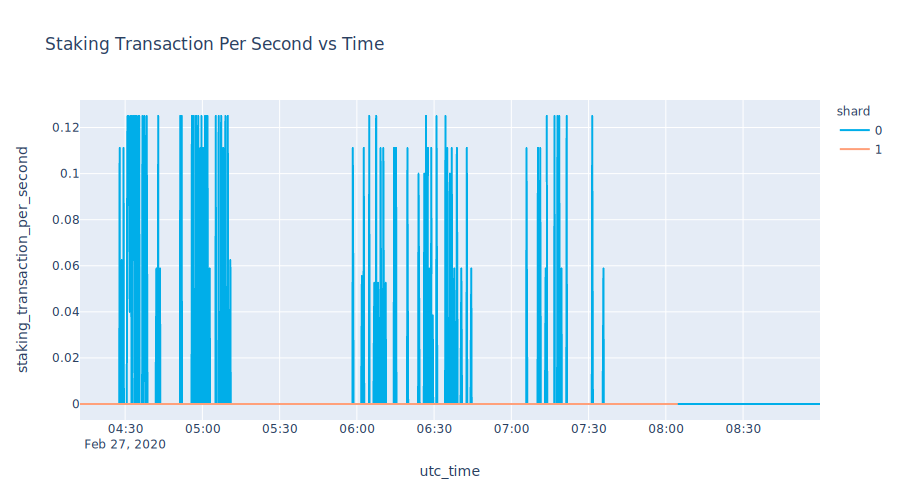

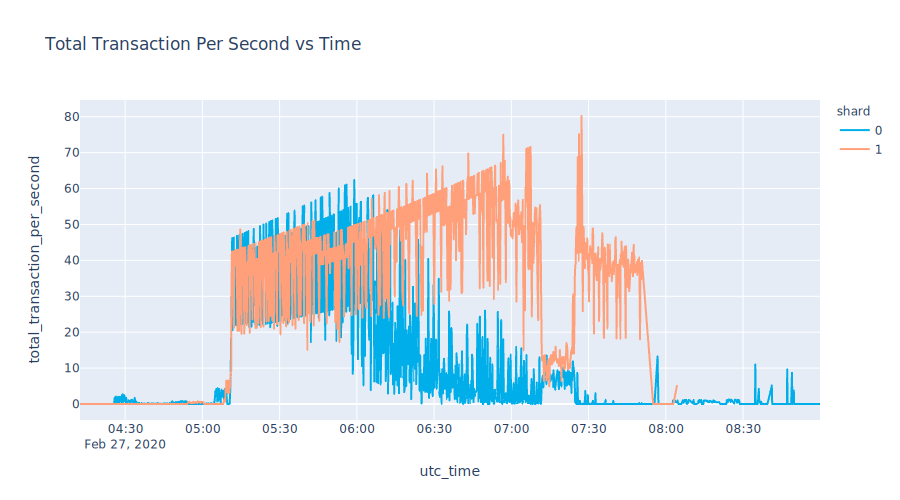

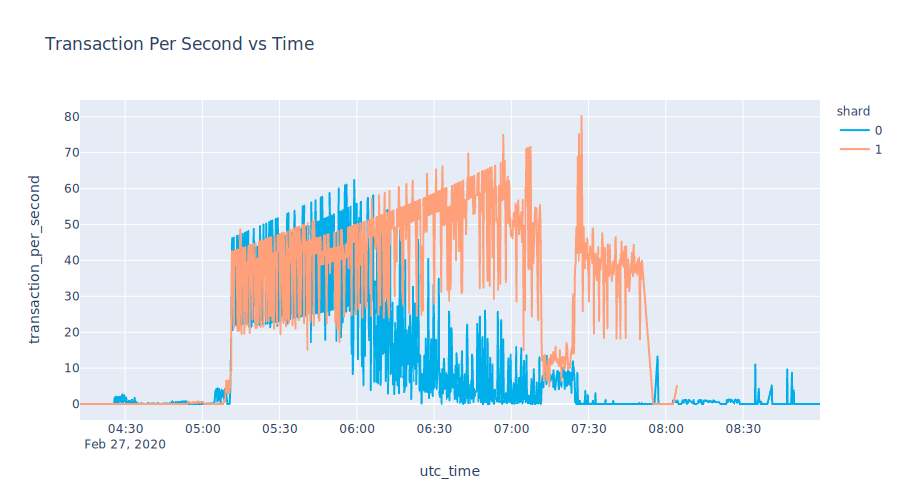

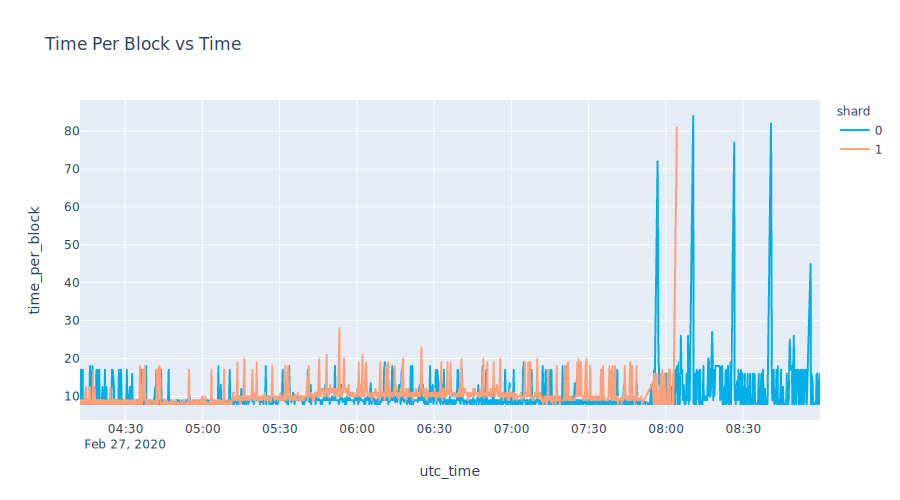

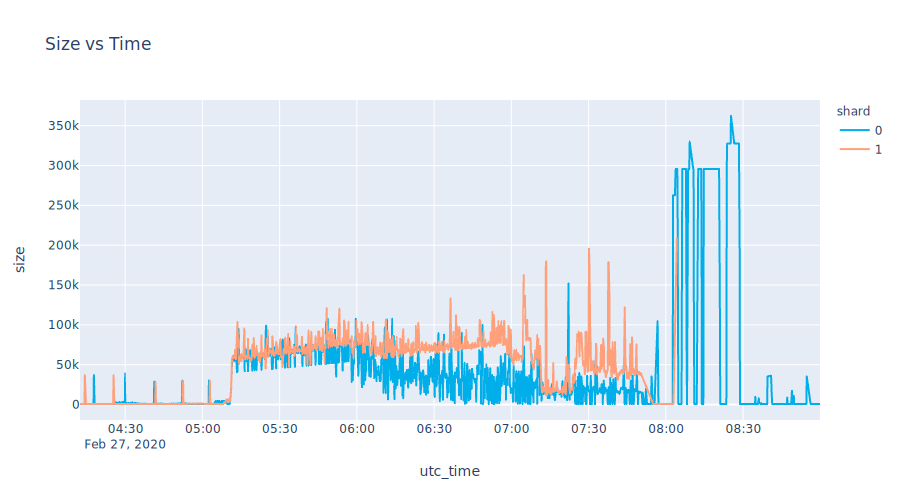

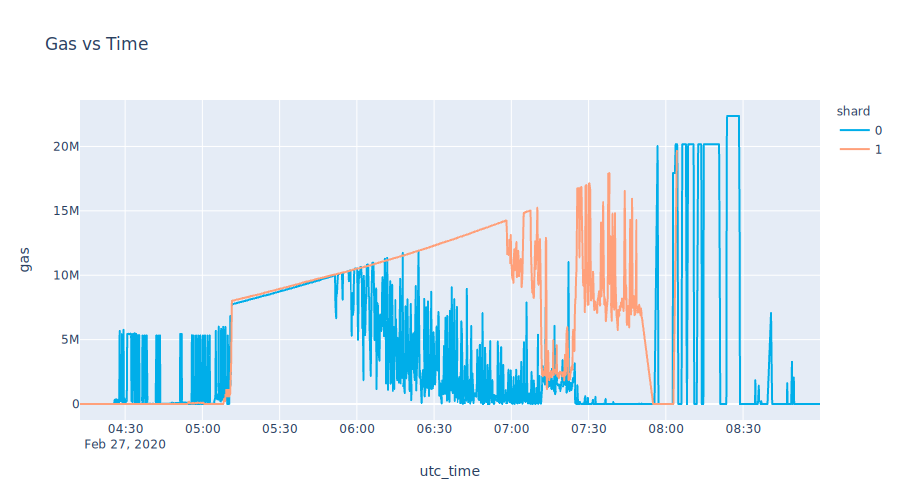

In [13]:
if __name__ == "__main__":

    if os.path.exists(fig_dir):
        shutil.rmtree(fig_dir)
    os.mkdir(fig_dir)
    
    files = os.listdir(log_dir)
    data = read_data(files, log_dir)
    shard = data_processing(data, start_time, end_time)
    colors = colors[:len(shard)]
    
    ## get the index of the new chain started
    index = []
    for s in shard:
        i = s[s['time_per_block'] < 0].index.tolist()  
        if len(i) == 0:
            break
        i.insert(0,0)
        i.append(len(s))
        index.append(i)
     
    if len(index) == 0:
        new = pd.concat(shard)
        visualization(new, fig_dir)
    else:
        for i in range(len(index[0])-1):
            df = []
            for s in range(len(shard)):
                df.append(shard[s].iloc[index[s][i]+1:index[s][i+1]])
            new = pd.concat(df)

            fig_path = fig_dir + "chain_" + str(i)  
            if not os.path.exists(fig_path):
                os.makedirs(fig_path)
            visualization(new, fig_path)

            